In [28]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [29]:
from utils import plot_iroot, comp_kde, kdeplot, kdeplot2, compare, get_kde_eval, norm

In [30]:
d1 = ad.read_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2 = ad.read_h5ad("data/dynchro2_slingshot_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

In [31]:
d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

In [32]:
d1.write("data/fastmnn1.h5ad")
d2.write("data/fastmnn2.h5ad")

In [33]:
fastmnn= ad.read_h5ad("data/fastmnn_result.h5ad")

## Fastmnn

In [34]:
fastmnn

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'batch'
    obsm: 'corrected'

In [38]:
d1.obs

,step_ix,simulation_i,sim_time,milestones,leiden,dpt_pseudotime,orig_linD_pseudotime,orig_linC_pseudotime,linD,linC
cell1,4972,62,150.083333,sD,0,0.183115,23.534008,23.849089,TRUE,TRUE
cell2,7919,98,460.083333,sD,4,0.616939,42.164078,NaN,TRUE,FALSE
cell3,54,1,380.083333,sEndD,4,0.655404,41.690671,NaN,TRUE,FALSE
cell4,2870,36,190.000000,sD,0,0.143597,20.238094,21.807524,TRUE,TRUE
cell5,4848,60,530.083333,sEndC,5,0.933513,NaN,57.245446,FALSE,TRUE
...,...,...,...,...,...,...,...,...,...,...
cell996,5932,74,30.083333,sB,3,0.071835,5.537482,5.549768,TRUE,TRUE
cell997,285,4,260.000000,sEndC,2,0.723212,NaN,44.771050,FALSE,TRUE
cell998,2154,27,320.083333,sC,2,0.691167,NaN,39.289618,FALSE,TRUE
cell999,6114,76,230.000000,sD,1,0.268930,28.014987,NaN,TRUE,FALSE


In [39]:
fastmnn.obsm["X_fastmnn"] = fastmnn.obsm["corrected"]
fastmnn.obs["milestones"] = np.concatenate((d1.obs["milestones"], d2.obs["milestones"]))
fastmnn.obs["sim_time"] = np.concatenate((d1.obs["sim_time"], d2.obs["sim_time"]))
fastmnn.obs["batch"] = [0] * d1.shape[0] + [1] * d2.shape[0]
fastmnn.obs["linC"] = np.concatenate((d1.obs["linC"], d2.obs["linC"]))
fastmnn.obs["linD"] = np.concatenate((d1.obs["linD"], d2.obs["linD"]))
fastmnn.obs["orig_linC_pseudotime"] = np.concatenate((d1.obs["orig_linC_pseudotime"], d2.obs["orig_linC_pseudotime"]))
fastmnn.obs["orig_linD_pseudotime"] = np.concatenate((d1.obs["orig_linD_pseudotime"], d2.obs["orig_linD_pseudotime"]))

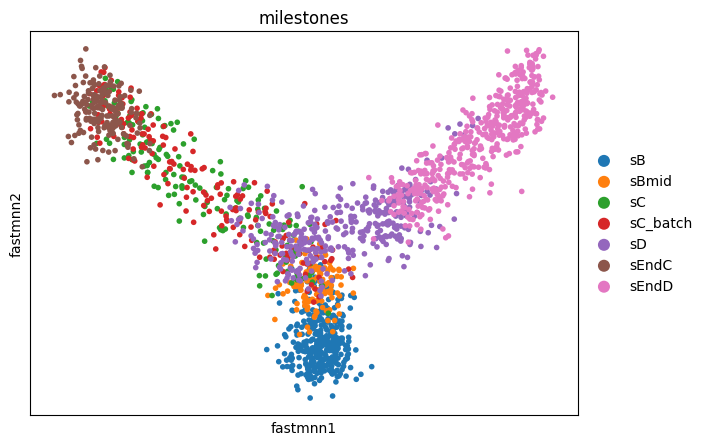

In [40]:
sc.pl.scatter(fastmnn, basis = "fastmnn", color = "milestones")

In [41]:
fastmnn.obs

,batch,milestones,sim_time,linC,linD,orig_linC_pseudotime,orig_linD_pseudotime
1,0,sD,150.083333,TRUE,TRUE,23.849089,23.534008
2,0,sD,460.083333,FALSE,TRUE,NaN,42.164078
3,0,sEndD,380.083333,FALSE,TRUE,NaN,41.690671
4,0,sD,190.000000,TRUE,TRUE,21.807524,20.238094
5,0,sEndC,530.083333,TRUE,FALSE,57.245446,NaN
...,...,...,...,...,...,...,...
1818,1,sC_batch,160.000000,TRUE,TRUE,29.337826,22.465927
1819,1,sEndD,380.083333,FALSE,TRUE,NaN,35.284809
1820,1,sD,240.000000,TRUE,TRUE,23.197623,21.402175
1821,1,sD,130.083333,TRUE,TRUE,21.857863,20.149078


In [42]:
sc.pp.neighbors(fastmnn, use_rep="X_fastmnn")


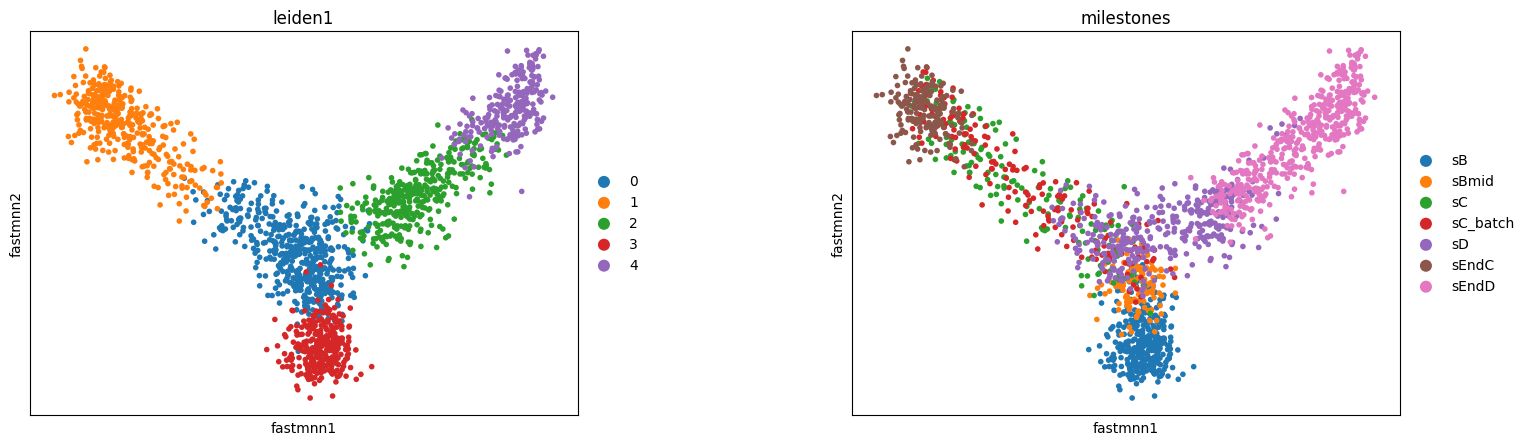

In [43]:
sc.tl.leiden(fastmnn, resolution=1, key_added="leiden1")
sc.pl.scatter(fastmnn, basis="fastmnn", color=["leiden1", "milestones"])


In [44]:
fastmnn.write("data/fastmnn.h5ad")

## Pseudotime

In [45]:
fastmnn_result = ad.read_h5ad("data/fastmnn_slingshot.h5ad")

In [46]:
fastmnn_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'batch', 'milestones', 'sim_time', 'linC', 'linD', 'orig_linC_pseudotime', 'orig_linD_pseudotime', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors'
    obsm: 'X_fastmnn', 'corrected'
    layers: 'X'
    obsp: 'connectivities', 'distances'

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


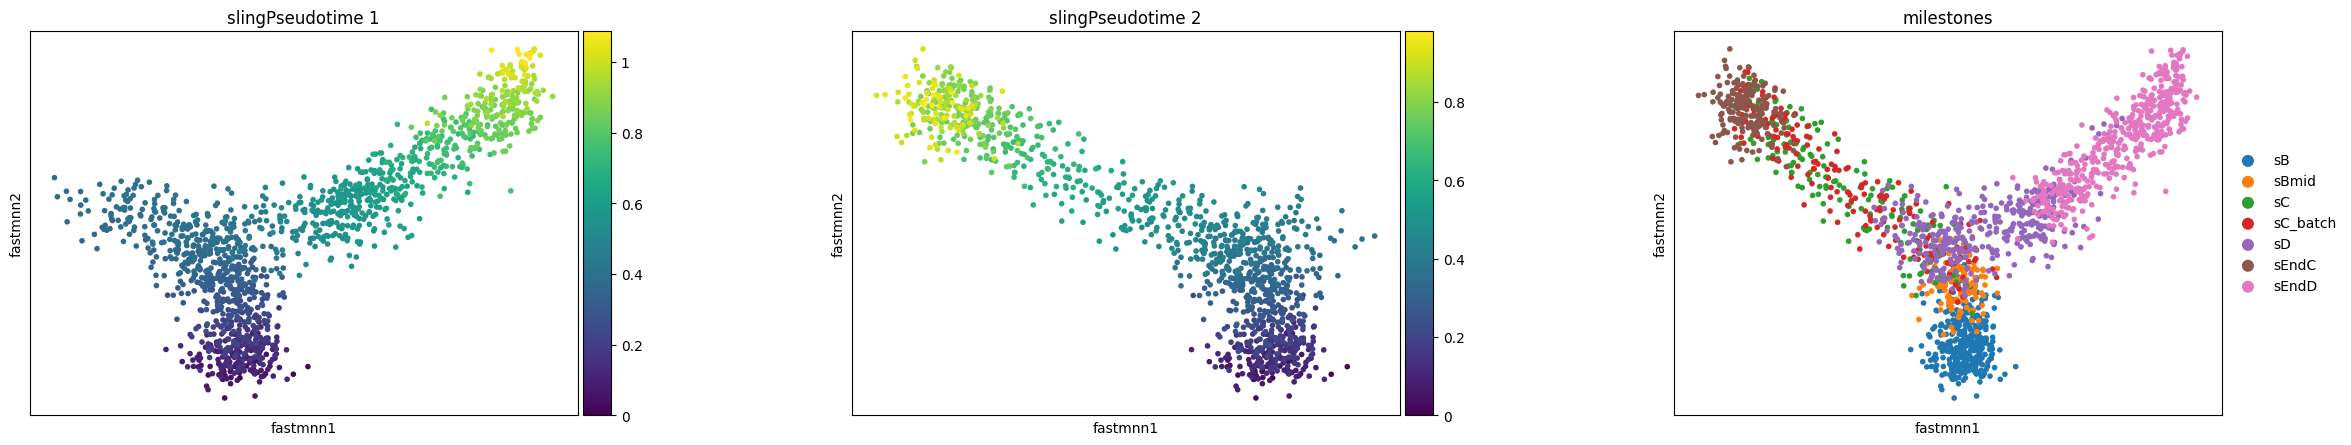

In [47]:
sc.pl.scatter(fastmnn_result, basis = "fastmnn", color = ["slingPseudotime_1", "slingPseudotime_2", "milestones"])

In [61]:
clin = fastmnn_result[~fastmnn_result.obs["slingPseudotime_2"].isna()]
dlin = fastmnn_result[~fastmnn_result.obs["slingPseudotime_1"].isna()]

In [62]:
# make category of batches
clin.obs["batch"] = clin.obs["batch"].astype("category")
dlin.obs["batch"] = dlin.obs["batch"].astype("category")

/tmp/ipykernel_201849/1776503470.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  clin.obs["batch"] = clin.obs["batch"].astype("category")
/tmp/ipykernel_201849/1776503470.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dlin.obs["batch"] = dlin.obs["batch"].astype("category")


In [63]:
clin.obs["batch"]

1       0
4       0
5       0
6       0
7       0
       ..
1815    1
1818    1
1820    1
1821    1
1822    1
Name: batch, Length: 1208, dtype: category
Categories (2, int32): [0, 1]

# KDE plots

In [ ]:
clin.obs["sim_time_norm"] = (clin.obs["sim_time"] - clin.obs["sim_time"].min()) / (clin.obs["sim_time"].max() - clin.obs["sim_time"].min())

View of AnnData object with n_obs × n_vars = 180 × 531
    obs: 'batch', 'milestones', 'sim_time', 'linC', 'linD', 'orig_linC_pseudotime', 'orig_linD_pseudotime', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2', 'sim_time_norm'
    uns: 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors'
    obsm: 'X_fastmnn', 'corrected'
    layers: 'X'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 180 × 531
    obs: 'batch', 'milestones', 'sim_time', 'linC', 'linD', 'orig_linC_pseudotime', 'orig_linD_pseudotime', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2', 'sim_time_norm'
    uns: 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors'
    obsm: 'X_fastmnn', 'corrected'
    layers: 'X'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 59 × 531
    obs: 'batch', 'milestones', 'sim_time', 'linC', 'linD', 'orig_linC_pseudotime', 'orig_linD_pseudotime', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2

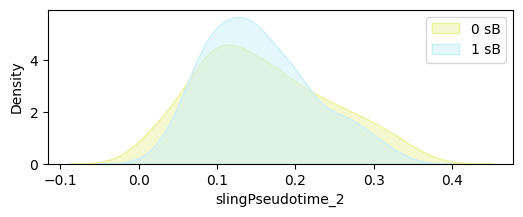

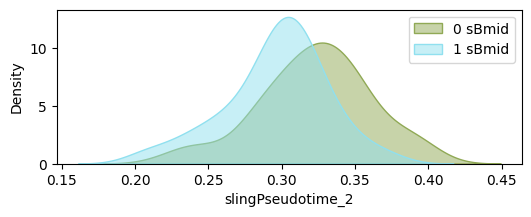

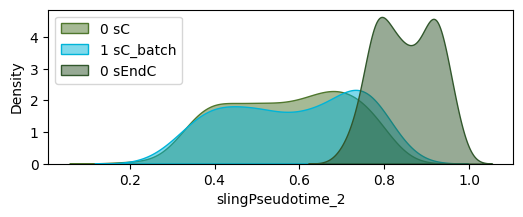

In [65]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", time_column = "slingPseudotime_2", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(clin, "sBmid",time_column = "slingPseudotime_2", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(clin, 0, "sC",time = "slingPseudotime_2", milestone_column = "milestones", color="#4f772d")
    kdeplot2(clin, 1, "sC_batch",time = "slingPseudotime_2", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(clin, 0, "sEndC", time = "slingPseudotime_2",milestone_column = "milestones", color="#31572c")
    plt.legend()

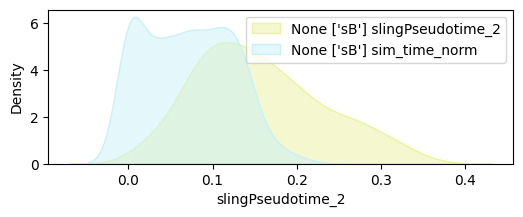

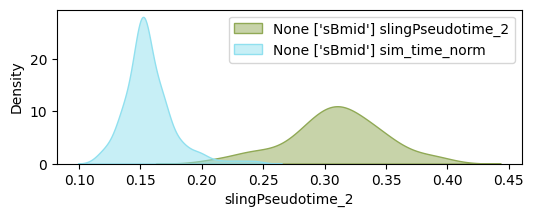

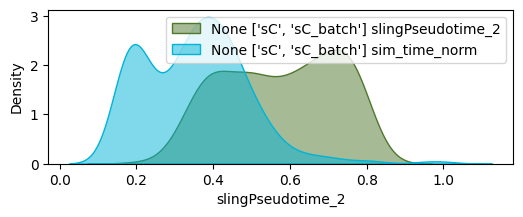

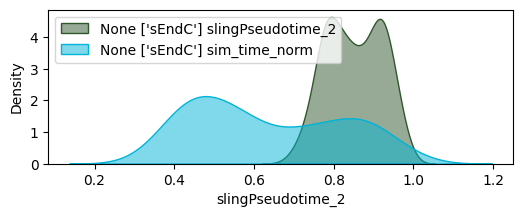

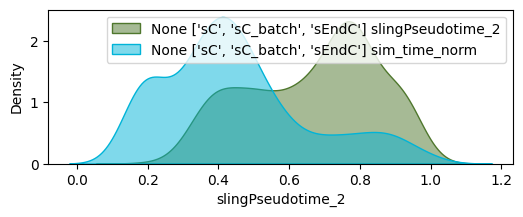

In [66]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    compare(clin, "sB", time1 = "slingPseudotime_2", time2 = "sim_time_norm", colors = ["#ecf39e", "#caf0f8"])
    plt.figure()
    compare(clin, "sBmid", time1 = "slingPseudotime_2", time2 = "sim_time_norm", colors = ["#90a955", "#90e0ef"])
    plt.figure()
    compare(clin, ["sC", "sC_batch"], time1 = "slingPseudotime_2", time2 = "sim_time_norm", colors = ["#4f772d", "#00b4d8"])
    plt.figure()
    compare(clin, "sEndC", time1 = "slingPseudotime_2", time2 = "sim_time_norm", colors = ["#31572c", "#00b4d8"])
    plt.figure()
    compare(clin, ["sC", "sC_batch", "sEndC"], time1 = "slingPseudotime_2", time2 = "sim_time_norm", colors = ["#4f772d", "#00b4d8"])
    

# Metrics

In [67]:
clin_after = clin
dlin_after = dlin

# select all where linC is True
clin_before = fastmnn_result[fastmnn_result.obs.linC == "TRUE"]
dlin_before = fastmnn_result[fastmnn_result.obs.linD == "TRUE"]

In [68]:
clin_before

View of AnnData object with n_obs × n_vars = 1186 × 531
    obs: 'batch', 'milestones', 'sim_time', 'linC', 'linD', 'orig_linC_pseudotime', 'orig_linD_pseudotime', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors'
    obsm: 'X_fastmnn', 'corrected'
    layers: 'X'
    obsp: 'connectivities', 'distances'

In [69]:
clin_after.obs

,batch,milestones,sim_time,linC,linD,orig_linC_pseudotime,orig_linD_pseudotime,leiden1,slingPseudotime_1,slingPseudotime_2,sim_time_norm
1,0,sD,150.083333,TRUE,TRUE,23.849089,23.534008,0,0.439848,0.453992,0.227813
4,0,sD,190.000000,TRUE,TRUE,21.807524,20.238094,0,0.380964,0.413240,0.288403
5,0,sEndC,530.083333,TRUE,FALSE,57.245446,NaN,1,NaN,0.928206,0.804620
6,0,sEndC,440.083333,TRUE,FALSE,51.623796,NaN,1,NaN,0.919103,0.668007
7,0,sB,90.083333,TRUE,TRUE,14.986977,14.718958,0,0.276602,0.285051,0.136739
...,...,...,...,...,...,...,...,...,...,...,...
1815,1,sB,70.000000,TRUE,TRUE,13.102101,12.658837,3,0.192442,0.193284,0.106254
1818,1,sC_batch,160.000000,TRUE,TRUE,29.337826,22.465927,0,0.386121,0.510310,0.242866
1820,1,sD,240.000000,TRUE,TRUE,23.197623,21.402175,0,0.353582,0.358200,0.364299
1821,1,sD,130.083333,TRUE,TRUE,21.857863,20.149078,0,0.333762,0.347931,0.197455


In [70]:
cbx, cby, cbkde = get_kde_eval(norm(clin_before.obs.orig_linC_pseudotime), bandwith=0.1)
dbx, dby, dbkde = get_kde_eval(norm(dlin_before.obs.orig_linD_pseudotime), bandwith=0.1)

cax, cay, cakde = get_kde_eval(norm(clin_after.obs.slingPseudotime_2), bandwith=0.1)
dax, day, dakde = get_kde_eval(norm(dlin_after.obs.slingPseudotime_1), bandwith=0.1)

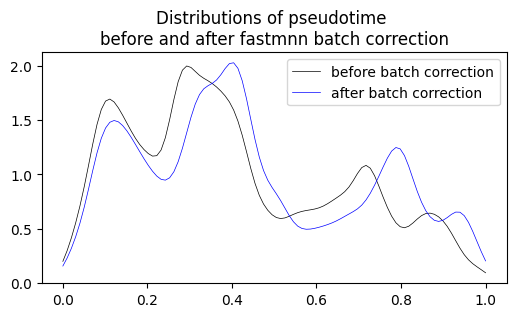

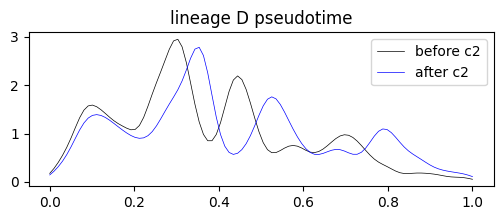

In [74]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(cbx, cby, color="black", lw=0.5, label="before batch correction")
ax.plot(cax, cay, color="blue", lw=0.5, label="after batch correction")
plt.title("Distributions of pseudotime \nbefore and after fastmnn batch correction")
plt.legend()
plt.show()
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(dbx, dby, color="black", lw=0.5, label="before c2")
ax.plot(dax, day, color="blue", lw=0.5, label="after c2")
plt.title("lineage D pseudotime")
plt.legend()
plt.show()

In [72]:
c_wasserstein = scipy.stats.wasserstein_distance(cbx, cax, cby, cay)
print(f"Wasserstein distance before vs after C: {c_wasserstein}")
d_wasserstein = scipy.stats.wasserstein_distance(dbx, dax, dby, day)
print(f"Wasserstein distance before vs after D: {d_wasserstein}")

Wasserstein distance before vs after C: 0.03986652925881021
Wasserstein distance before vs after D: 0.05361566451520634
